# Introduction


Ocular Disease Recognition dataset

* Normal (N);  
* Diabetes (D);  
* Glaucoma (G);  
* Cataract (C);  
* AMD (A);  
* Hypertension (H);  
* Myopia (M);
* Other diseases/abnormalities (O)  


This project focuses on Cataract.


# Data Preprocessing

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shashidhargadepalli","key":"daa7ceb09fdf86b2cda1ad4b529aa0cf"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 99% 1.61G/1.62G [00:17<00:00, 115MB/s]
100% 1.62G/1.62G [00:17<00:00, 97.6MB/s]


In [ ]:
!unzip ocular-disease-recognition-odir5k.zip -d odir_data


Streaming output truncated to the last 5000 lines.
  inflating: odir_data/preprocessed_images/2179_left.jpg  
  inflating: odir_data/preprocessed_images/2179_right.jpg  
  inflating: odir_data/preprocessed_images/217_left.jpg  
  inflating: odir_data/preprocessed_images/217_right.jpg  
  inflating: odir_data/preprocessed_images/2180_left.jpg  
  inflating: odir_data/preprocessed_images/2180_right.jpg  
  inflating: odir_data/preprocessed_images/2181_left.jpg  
  inflating: odir_data/preprocessed_images/2181_right.jpg  
  inflating: odir_data/preprocessed_images/2182_left.jpg  
  inflating: odir_data/preprocessed_images/2182_right.jpg  
  inflating: odir_data/preprocessed_images/2183_left.jpg  
  inflating: odir_data/preprocessed_images/2183_right.jpg  
  inflating: odir_data/preprocessed_images/2184_left.jpg  
  inflating: odir_data/preprocessed_images/2184_right.jpg  
  inflating: odir_data/preprocessed_images/2185_left.jpg  
  inflating: odir_data/preprocessed_images/2185_right.jpg  

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "/content/odir_data/ODIR-5K/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
# import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline

In [ ]:
data_df = pd.read_excel(open("/content/odir_data/ODIR-5K/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')

In [ ]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [ ]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [ ]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [ ]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values

non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values


In [ ]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)


In [ ]:
print(len(os.listdir(DATA_FOLDER)))

7000


In [ ]:
from concurrent.futures import ThreadPoolExecutor
import os
import cv2 as cv
import numpy as np
from random import shuffle
from tqdm import tqdm

def label_image(label):
    if label == 1:
        return [1, 0]
    elif label == 0:
        return [0, 1]

def process_single_image(img, DATA_FOLDER, is_cataract):
    path = os.path.join(DATA_FOLDER, img)
    label = label_image(is_cataract)
    img = cv.imread(path, cv.IMREAD_COLOR)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
    return [np.array(img), np.array(label)]

def process_data(data_image_list, DATA_FOLDER, is_cataract, num_workers=4):
    data_df = []

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_single_image, img, DATA_FOLDER, is_cataract) for img in data_image_list]
        for future in tqdm(futures):
            data_df.append(future.result())

    shuffle(data_df)
    return data_df


In [ ]:
len(non_cataract_list)

300

In [ ]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 300/300 [00:04<00:00, 60.21it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(data, isTest=False):
    labels_map = ['Cataract', 'No Cataract']

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    if isTest:
        str_label = 'None'

    for i, data_item in enumerate(data[:9]):
        img_data, img_label = data_item[0], data_item[1]

        if not isTest:
            label_index = np.argmax(img_label)
            str_label = labels_map[label_index]

        row, col = divmod(i, 3)

        axes[row, col].imshow(img_data)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Label: {str_label}")

    plt.show()

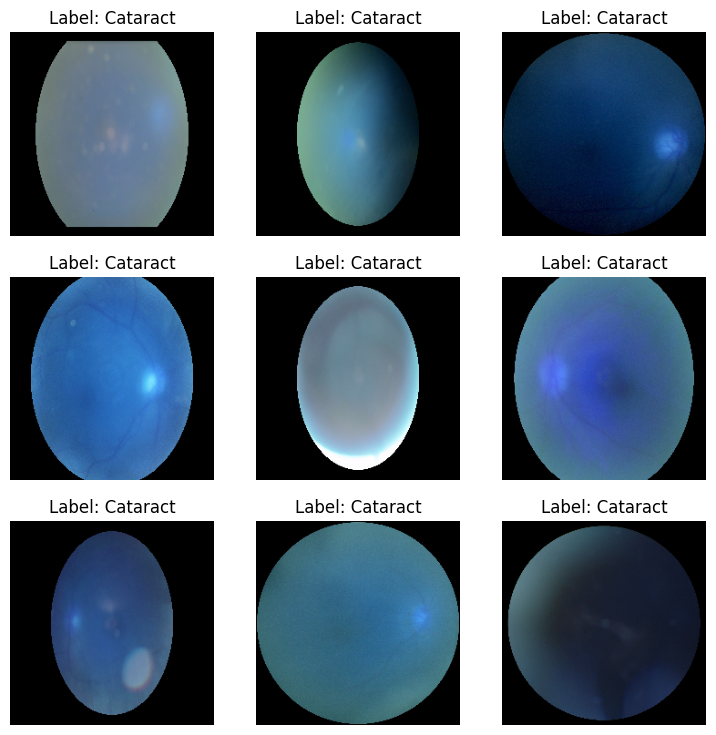

In [ ]:
show_images(cat_df)

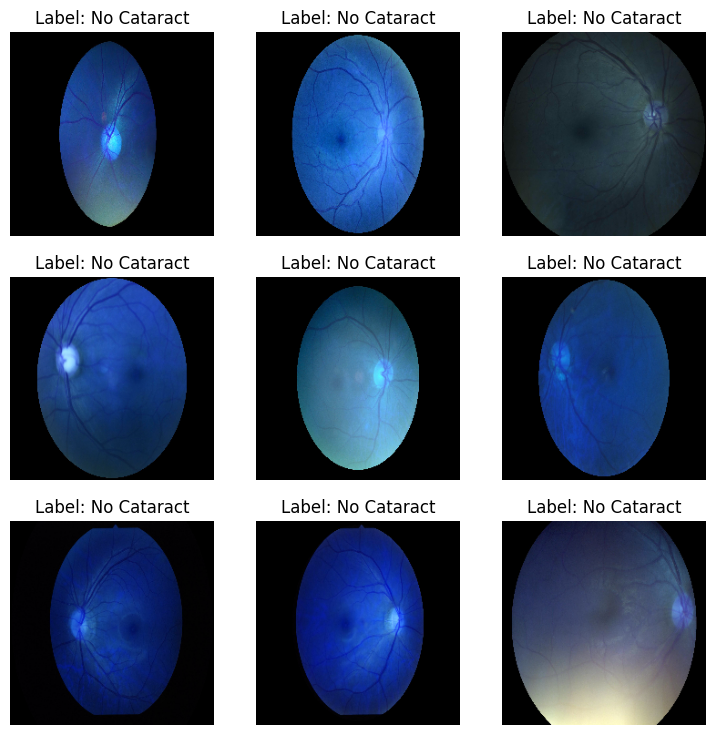

In [ ]:
show_images(cat_no_df)

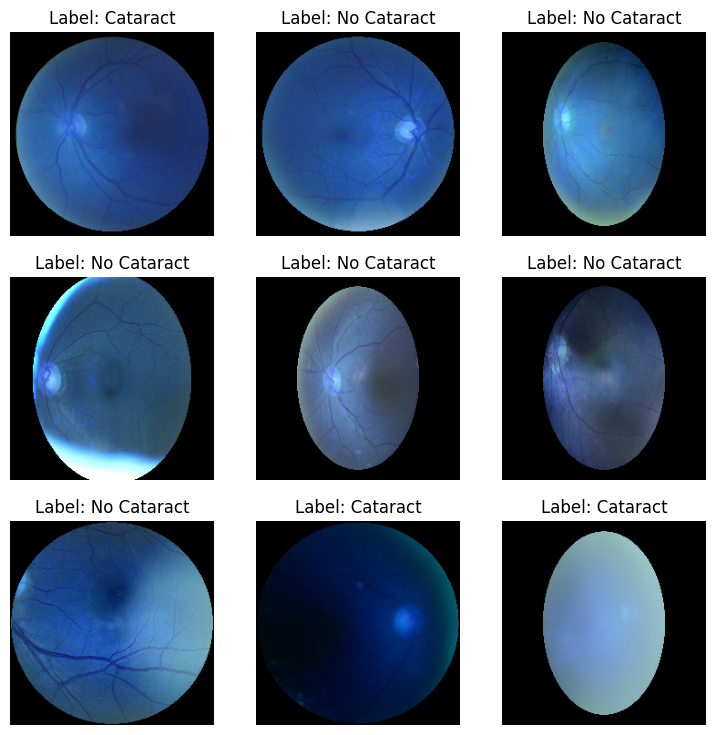

In [ ]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

## Train Neural Network -- CNN Efficient NET

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [ ]:
img_shape = (224, 224, 3)


In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import keras

In [ ]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5
batches = int(np.ceil(2 / batch_size))


In [ ]:
###Using Callback and efficient Net

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_train_begin(self, logs=None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr = lr
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1

        else:
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                else:
                    self.count = self.count + 1

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

img_shape=(224,224,3)
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016),
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(2, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(f"Accuracy on test set: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.6778 - loss: 25.5614 - val_accuracy: 0.5285 - val_loss: 14.9474
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.6101 - loss: 8.8439 - val_accuracy: 0.5285 - val_loss: 9.3084
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.5320 - loss: 7.4279 - val_accuracy: 0.4715 - val_loss: 10.7015
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.5226 - loss: 6.8996 - val_accuracy: 0.5285 - val_loss: 6.8757
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.5281 - loss: 6.6175 - val_accuracy: 0.5285 - val_loss: 6.4046
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.5411 - loss: 6.3070 - val_accuracy: 0.5285 - val_loss: 6.1143
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - accuracy: 0.4850 - loss: 6.0569 - val_accuracy: 0.5285 - val_loss: 5.8344
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.5035 - loss: 5.9844 - val_accuracy: